In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/10cells"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from utils import GetSourcePts, ApproxPSFBesselModel, InverseMatrix, ApproxPSFBesselOptimise

In [3]:
ASSUMED_NOISE_LEVEL = 1e7

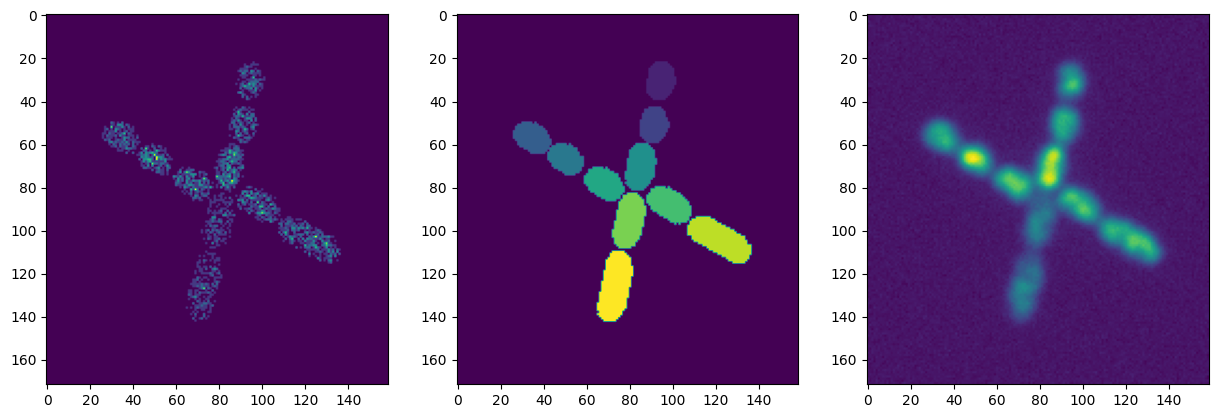

In [4]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

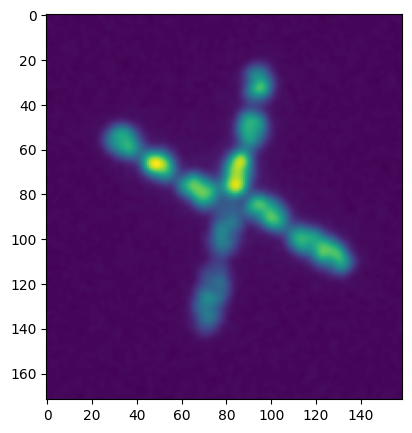

In [5]:
#Apply gaussian filter to out

outBlur = gaussian_filter(out, sigma=1)
plt.imshow(outBlur)

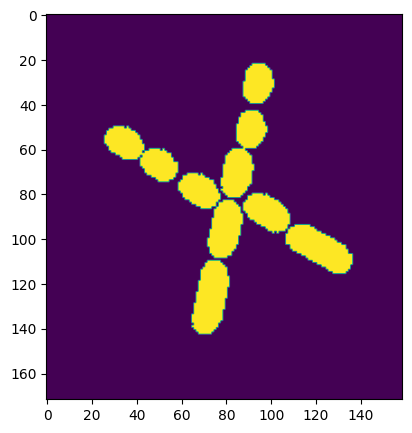

In [6]:
#IMPT: All mask values are set to one
maskUnit = mask.copy()

for i in range(len(mask)):
    for j in range(len(mask[0])):
        if (mask[i][j] != 0):
            maskUnit[i][j] = 1

plt.imshow(maskUnit)

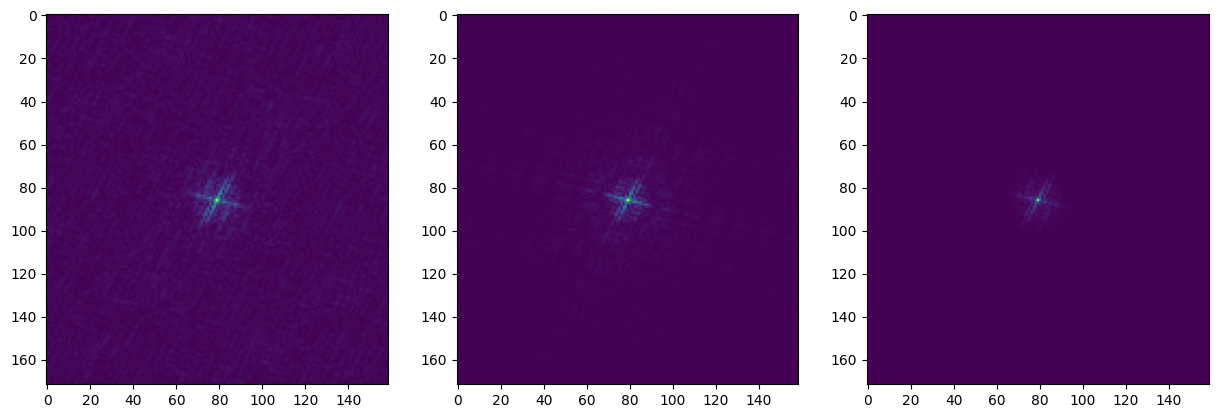

In [7]:


# Compute the 2d FFT of the input image
oriFreq = fftpack.fft2(ori)
maskFreq = fftpack.fft2(maskUnit)
outFreq = fftpack.fft2(outBlur)

# Shift the zero-frequency component to the center of the spectrum.
oriFreq = fftpack.fftshift(oriFreq)
maskFreq = fftpack.fftshift(maskFreq)
outFreq = fftpack.fftshift(outFreq)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(oriFreq))
axarr[1].imshow(np.abs(maskFreq))
axarr[2].imshow(np.abs(outFreq))
plt.show()

In [8]:
#Transform mask.shape into odd values

psfShape = [0,0]
psfShape[0] = mask.shape[0] + 1 if mask.shape[0] % 2 == 0 else mask.shape[0]
psfShape[1] = mask.shape[1] + 1 if mask.shape[1] % 2 == 0 else mask.shape[1]


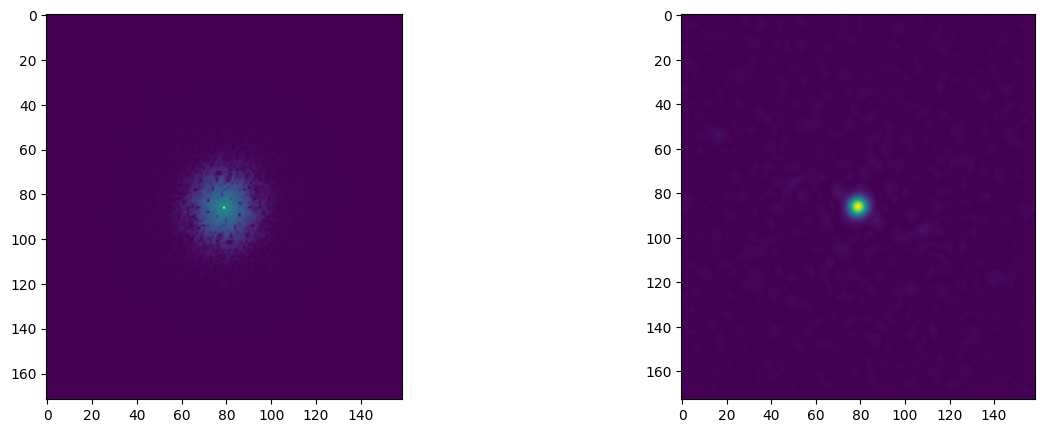

In [9]:
psfFreqIdeal = outFreq * np.conj(oriFreq) / (np.abs(oriFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(oriFreq)**2))
psfIdeal = fftpack.ifft2(psfFreqIdeal,shape=psfShape)
psfIdeal = fftpack.fftshift(psfIdeal)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.abs(psfFreqIdeal))
axarr[1].imshow(np.abs(psfIdeal))
plt.show()

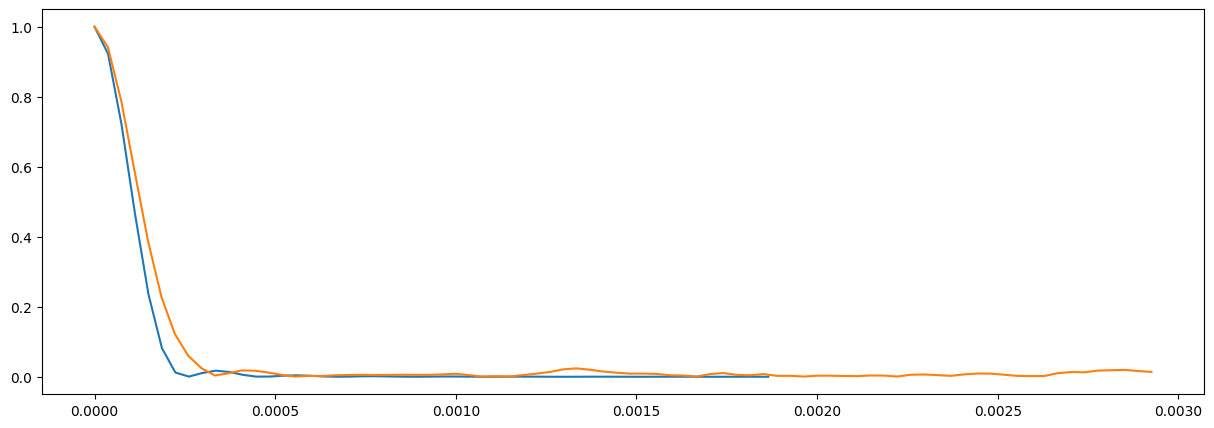

In [10]:
(maskWidth, maskHeight) = mask.shape
maskSize = maskWidth*maskHeight

#Normalise x axis of original psf to 1
original_psf_y = psf[len(psf)//2]
original_psf_y = original_psf_y[len(original_psf_y)//2:]
original_psf_x = np.linspace(0,1,len(original_psf_y))*len(original_psf_y)/maskSize
plt.plot(original_psf_x,original_psf_y)

new_psf_y = np.abs(psfIdeal)
new_psf_y = new_psf_y/max(new_psf_y.flatten())
new_psf_y = new_psf_y[len(new_psf_y)//2]
new_psf_y = new_psf_y[len(new_psf_y)//2:]
new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize

plt.plot(new_psf_x,new_psf_y)
plt.show()


[-28.75328727] [[0.0325127]]


/home/boomalope/symbac/symbac/tests/dx_test_env/utils.py:289: RuntimeWarning: invalid value encountered in double_scalars
  return (2*jv(1,x*a) / (x*a))**2


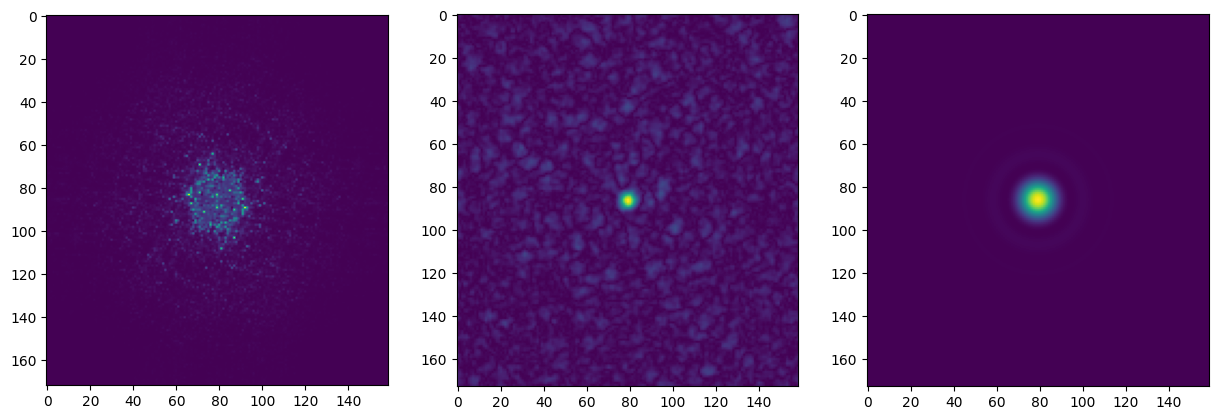

In [16]:

#We try to find psf with mask instead

psfFreqMask= outFreq * np.conj(maskFreq) / (np.abs(maskFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(maskFreq)**2))
psfMask = fftpack.ifft2(psfFreqMask, shape=psfShape)
psfMask = fftpack.fftshift(psfMask)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(psfFreqMask))
axarr[1].imshow(np.abs(psfMask))

#Add some noise to the psf
import random

psfDup = np.abs(psf) + np.random.normal(0,0.2,psf.shape)

#Blur psf with gaussian
#psfSmooth = gaussian_filter(np.abs(psfMask), sigma=1)
psfModel = ApproxPSFBesselOptimise(np.abs(psfIdeal)/max(np.abs(psfMask).flatten()))

axarr[2].imshow(np.abs(psfModel))


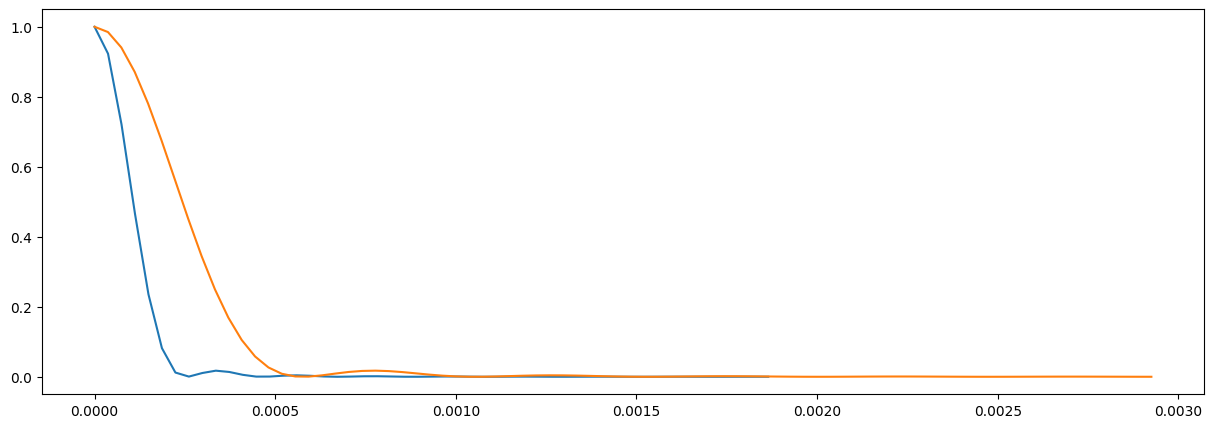

In [12]:
(maskWidth, maskHeight) = mask.shape
maskSize = maskWidth*maskHeight

#Normalise x axis of original psf to 1
original_psf_y = psf[len(psf)//2]
original_psf_y = original_psf_y[len(original_psf_y)//2:]
original_psf_x = np.linspace(0,1,len(original_psf_y))*len(original_psf_y)/maskSize
plt.plot(original_psf_x,original_psf_y)

new_psf_y = np.abs(psfModel)
new_psf_y = new_psf_y/max(new_psf_y.flatten())
new_psf_y = new_psf_y[len(new_psf_y)//2]
new_psf_y = new_psf_y[len(new_psf_y)//2:]
new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize
plt.plot(new_psf_x,new_psf_y)
plt.show()

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[[0.74438105]
 [0.78431156]
 [0.80753759]
 [1.        ]
 [0.95463413]
 [0.81896402]
 [0.75872975]
 [0.39230254]
 [0.81241817]
 [0.50847039]]


array([[1.        , 0.23747435],
       [0.23747435, 1.        ]])

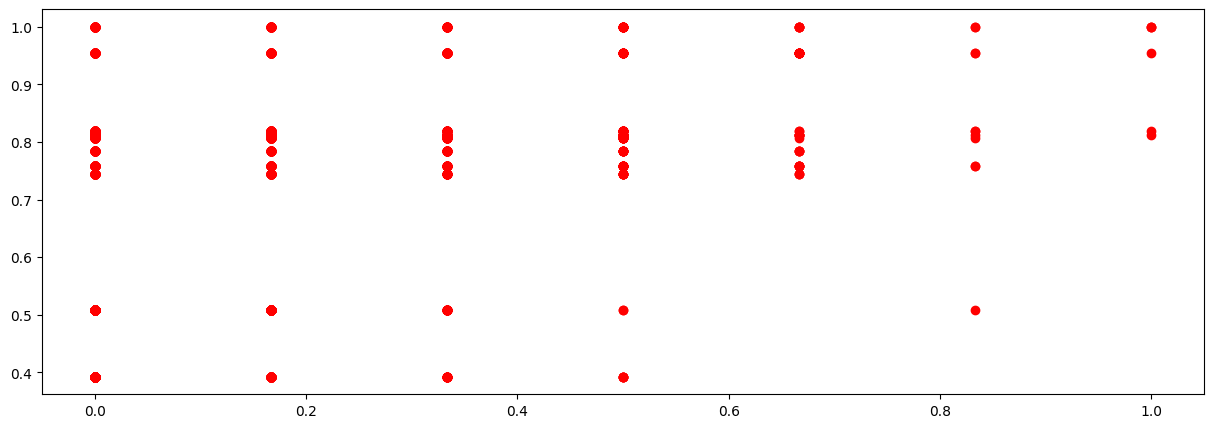

In [13]:
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, adjPts=5, learningRate = 1, psf=psfModel)

original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(recoveredImage[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)

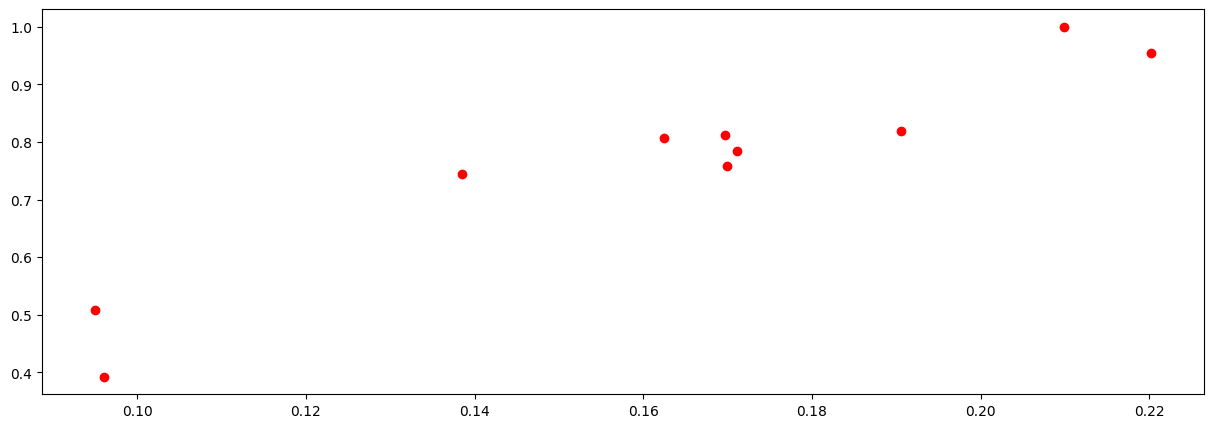

array([[1.        , 0.95362517],
       [0.95362517, 1.        ]])

In [14]:
#Get average intensity in each mask

average_original_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_original_intensity:
        average_original_intensity[mask[x[0],x[1]]] = [ori[x[0],x[1]],1]
    else:
        average_original_intensity[mask[x[0],x[1]]][0] += ori[x[0],x[1]]
        average_original_intensity[mask[x[0],x[1]]][1] += 1

average_custom_intensity = {}
for x in sourcePts:
    if not mask[x[0],x[1]] in average_custom_intensity:
        average_custom_intensity[mask[x[0],x[1]]] = [recoveredImage[x[0],x[1]],1]
    else:
        average_custom_intensity[mask[x[0],x[1]]][0] += recoveredImage[x[0],x[1]]
        average_custom_intensity[mask[x[0],x[1]]][1] += 1


average_original_intensity = [ v[0]/v[1] for k, v in average_original_intensity.items() ]
average_original_intensity = np.array(average_original_intensity)
average_inteaverage_original_intensitynsity = average_original_intensity/max(average_original_intensity)

average_custom_intensity = [ v[0]/v[1] for k, v in average_custom_intensity.items() ]
average_custom_intensity = np.array(average_custom_intensity)
average_custom_intensity = average_custom_intensity/max(average_custom_intensity)

plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
np.corrcoef(average_original_intensity,average_custom_intensity)

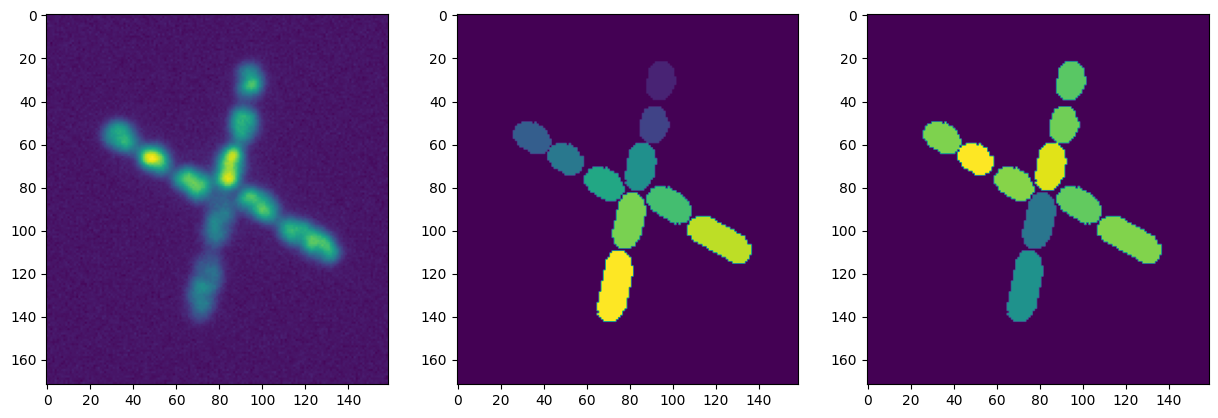

In [15]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(out)
axarr[1].imshow(mask)
axarr[2].imshow(recoveredImage)